# Epipolar Line

In [1]:
import cv2
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


def ComputeFundamentalMatrix(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    return pts1, pts2, F

In [2]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    try:
        r,c = img1.shape
        img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
        img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    except:
        r,c,ch = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [39]:
def DrawEpipolarLine(img1, img2, pts1, pts2, F):
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    #print(lines1)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    #print(lines2)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

In [30]:
img1 = cv2.imread('./data/left.jpg',0)  #queryimage # left image
img2 = cv2.imread('./data/right.jpg',0) #trainimage # right image
pts1, pts2, F = ComputeFundamentalMatrix(img1, img2)

[[ -2.03710958e-01  -9.79031086e-01   2.54721710e+02]
 [ -5.45262247e-02  -9.98512328e-01   1.73029312e+02]]
[[  -0.24664707    0.96910536 -116.71951294]
 [  -0.24791601    0.96878153  -67.50363922]]


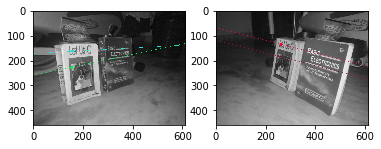

In [33]:
DrawEpipolarLine(img1, img2, pts1[3:5], pts2[3:5], F)

# Stero from Epipolar Geometry

https://rdmilligan.wordpress.com/2016/05/15/epipolar-geometry-and-depth-map-from-stereo-images/

loading images...
(1, 3)
(1, 3)


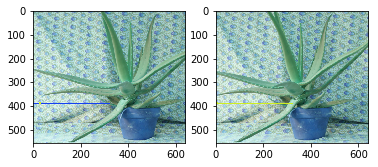

In [23]:
print('loading images...')
imgL = cv2.pyrDown( cv2.imread('data/aloeL.jpg') )  # downscale images for faster processing
imgR = cv2.pyrDown( cv2.imread('data/aloeR.jpg') )
pts1, pts2, F = ComputeFundamentalMatrix(imgL, imgR)
DrawEpipolarLine(imgL, imgR, pts1[0:1], pts2[0:1], F)

In [7]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [8]:
window_size = 3
min_disp = 16
num_disp = 112-min_disp
stereo = cv.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        blockSize = 16,
        P1 = 8*3*window_size**2,
        P2 = 32*3*window_size**2,
        disp12MaxDiff = 1,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32
    )

print('computing disparity...')
disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

print('generating 3d point cloud...',)
h, w = imgL.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                    [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
points = cv.reprojectImageTo3D(disp, Q)
colors = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
mask = disp > disp.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

#cv.imshow('left', imgL)
#cv.imshow('disparity', (disp-min_disp)/num_disp)
#cv.waitKey()
#cv.destroyAllWindows()

computing disparity...
generating 3d point cloud...
out.ply saved


# Stereo: Arbitrary perspective

In [54]:
# Copyright (2012) Julien Rebetez <julien@fhtagn.net>
import numpy as np
import cv2
import cv2 as cv
import numpy as np
import numpy.linalg as la
import pylab as pl
import matplotlib.cm as cm
def to_homg(x):
    """
    Transform x to homogeneous coordinates
    If X is MxN, returns an (M+1)xN array with ones on the last row
    >>> to_homg(np.array([[1, 2, 3], [1, 2, 3]], dtype=float))
    array([[ 1.,  2.,  3.],
           [ 1.,  2.,  3.],
           [ 1.,  1.,  1.]])
    >>> to_homg(np.array([[1], [2]]))
    array([[ 1.],
           [ 2.],
           [ 1.]])
    >>> to_homg([1, 2])
    array([1, 2, 1])
    """
    if hasattr(x, 'shape') and len(x.shape) > 1:
        return np.r_[x, np.ones((1,x.shape[1]))]
    else:
        return np.r_[x, 1]


def from_homg(x):
    """
    Transform homogeneous x to non-homogeneous coordinates
    If X is MxN, returns an (M-1)xN array that will contain nan when for
    columns where the last row was 0
    >>> from_homg(np.array([[1, 2, 3],
    ...                     [4, 5, 0]], dtype=float))
    array([[ 0.25,  0.4 ,   nan]])
    >>> from_homg(np.array([1, 5], dtype=float))
    array([ 0.2])
    >>> from_homg([1, 5, 0])
    array([ nan,  nan])
    >>> from_homg((1, 4, 0.5))
    array([ 2.,  8.])
    """
    if hasattr(x, 'shape') and len(x.shape) > 1:
        #valid = np.nonzero(x[-1,:])
        valid = x[-1,:] != 0
        result = np.empty((x.shape[0]-1, x.shape[1]), dtype=float)
        result[:,valid] = x[:-1,valid] / x[-1, valid]
        result[:,~valid] = np.nan
        return result
    else:
        if x[-1] == 0:
            result = np.empty(len(x)-1, dtype=float)
            result[:] = np.nan
            return result
        else:
            return np.array(x[:-1]) / x[-1]

In [61]:
def epipolar_lines(x1, F12):
    """
    Compute epipolar lines on second image corresponding to a list of
    points on first image
    As in cv.ComputecorrespondEpilines, line coefficient are normalized
    so that a^2 + b^2 = 1
    """
    def norm_line(l):
      nu = l[0]*l[0] + l[1]*l[1]
      return l * (1./np.sqrt(nu) if nu > 0 else 1.)
    return np.array([norm_line(F12.dot(to_homg(x))) for x in x1.T],
                    dtype=float).T

In [86]:

def rectify_uncalibrated(x1, x2, F, imsize, threshold=5):
    """
    Compute rectification homography for two images. This is based on
    algo 11.12.3 of HZ2
    This is also heavily inspired by cv::stereoRectifyUncalibrated
    Args:
        - imsize is (width, height)
    """
    U, W, V = la.svd(F)
    # Enforce rank 2 on fundamental matrix
    W[2] = 0
    W = np.diag(W)
    F = U.dot(W).dot(V)

    # Filter points based on their distance to epipolar lines
    if threshold > 0:
        lines1 = epipolar_lines(x1, F)
        lines2 = epipolar_lines(x2, F.T)

        def epi_threshold(i):
            return (abs(x1[0,i]*lines2[0,i] +
                        x1[1,i]*lines2[1,i] +
                        lines2[2,i]) <= threshold) and \
                    (abs(x2[0,i]*lines1[0,i] +
                         x2[1,i]*lines1[1,i] +
                         lines1[2,i]) <= threshold)

        inliers = filter(epi_threshold, range(x1.shape[1]))
    else:
        inliers = range(x1.shape[1])

    #assert len(inliers) > 0

    x1 = x1[:,inliers]
    x2 = x2[:,inliers]

    # HZ2 11.12.1 : Compute H = GRT where :
    # - T is a translation taking point x0 to the origin
    # - R is a rotation about the origin taking the epipole e' to (f,0,1)
    # - G is a mapping taking (f,0,1) to infinity

    # e2 is the left null vector of F (the one corresponding to the singular
    # value that is 0 => the third column of U)
    e2 = U[:,2]

    # TODO: They do this in OpenCV, not sure why
    if e2[2] < 0:
        e2 *= -1

    # Translation bringing the image center to the origin
    # FIXME: This is kind of stupid, but to get the same results as OpenCV,
    # use cv.Round function, which has a strange behaviour :
    # cv.Round(99.5) => 100
    # cv.Round(132.5) => 132
    cx = int((imsize[0]-1)*0.5)
    cy = int((imsize[1]-1)*0.5)

    T = np.array([[1, 0, -cx],
                  [0, 1, -cy],
                  [0, 0, 1]], dtype=float)

    e2 = T.dot(e2)
    mirror = e2[0] < 0

    # Compute rotation matrix R that should bring e2 to (f,0,1)
    # 2D norm of the epipole, avoid division by zero
    d = max(np.sqrt(e2[0]*e2[0] + e2[1]*e2[1]), 1e-7)
    alpha = e2[0]/d
    beta = e2[1]/d
    R = np.array([[alpha, beta, 0],
                  [-beta, alpha, 0],
                  [0, 0, 1]], dtype=float)

    e2 = R.dot(e2)

    # Compute G : mapping taking (f,0,1) to infinity
    invf = 0 if abs(e2[2]) < 1e-6*abs(e2[0]) else -e2[2]/e2[0]
    G = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [invf, 0, 1]], dtype=float)

    # Map the origin back to the center of the image
    iT = np.array([[1, 0, cx],
                   [0, 1, cy],
                   [0, 0, 1]], dtype=float)

    H2 = iT.dot(G.dot(R.dot(T)))

    # HZ2 11.12.2 : Find matching projective transform H1 that minimize
    # leaste-square distance between reprojected points
    e2 = U[:,2]

    # TODO: They do this in OpenCV, not sure why
    if e2[2] < 0:
        e2 *= -1

    e2_x = np.array([[0, -e2[2], e2[1]],
                     [e2[2], 0, -e2[0]],
                     [-e2[1], e2[0], 0]], dtype=float)

    e2_111 = np.array([[e2[0], e2[0], e2[0]],
                       [e2[1], e2[1], e2[1]],
                       [e2[2], e2[2], e2[2]]], dtype=float)

    H0 = H2.dot(e2_x.dot(F) + e2_111)

    # Minimize \sum{(a*x_i + b*y_i + c - x'_i)^2} (HZ2 p.307)
    # Compute H1*x1 and H2*x2
    x1h = to_homg(x1)
    x2h = to_homg(x2)
    A = H0.dot(x1h).T
    # We want last (homogeneous) coordinate to be 1 (coefficient of c
    # in the equation)
    A = (A.T / A[:,2]).T # for some reason, A / A[:,2] doesn't work
    B = H2.dot(x2h)
    B = B / B[2,:] # from homogeneous
    B = B[0,:] # only interested in x coordinate

    X, _, _, _ = la.lstsq(A, B)

    # Build Ha (HZ2 eq. 11.20)
    Ha = np.array([[X[0], X[1], X[2]],
                   [0, 1, 0],
                   [0, 0, 1]], dtype=float)

    H1 = Ha.dot(H0)

    if mirror:
        mm = np.array([[-1, 0, cx*2],
                       [0, -1, cy*2],
                       [0, 0, 1]], dtype=float)
        H1 = mm.dot(H1)
        H2 = mm.dot(H2)

    return H1, H2

(200, 266)
(2, 277)


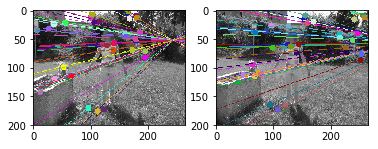

In [92]:
img1 = cv2.imread("data/human/image1.png",0)
img2 = cv2.imread("data/human/image2.png",0)
print(img1.shape)
K = np.load("data/human/K.npy")
d = np.load("data/human/d.npy")
x1 = np.load("data/human/x1.npy")
x2 = np.load("data/human/x2.npy")
print(x1.shape)

pts1, pts2, F = ComputeFundamentalMatrix(img1, img2)
DrawEpipolarLine(img1, img2, pts1, pts2, F)

In [121]:
H1, H2 = rectify_uncalibrated(pts1.T, pts2.T, F, (img1.shape[1], img1.shape[0]), threshold=0)

[[  8.31656463e-02  -9.42300750e-02   4.81522388e+01]
 [ -1.26732164e-01   4.26987825e-01   8.50048038e+00]
 [ -2.43715403e-03   9.87138705e-04   5.43623091e-01]]
[[  3.70294887e-01  -7.56042987e-02   9.06059005e+01]
 [ -2.57072533e-01   1.07311787e+00   2.66949054e+01]
 [ -4.61736051e-03   9.42741353e-04   1.51616019e+00]]
(300, 466)


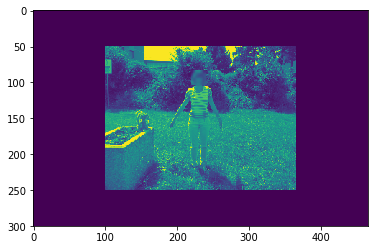

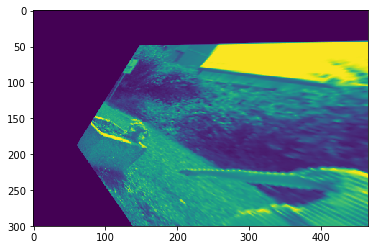

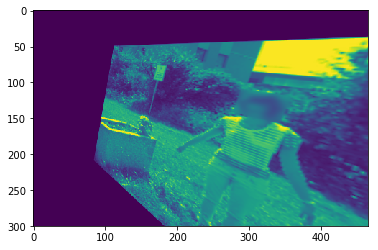

In [135]:
print(H1)
print(H2)
rimg1 = cv2.copyMakeBorder(img1,50,50,100,100, cv2.BORDER_CONSTANT)
plt.subplots()
plt.imshow(rimg1)
rimg2 = cv2.copyMakeBorder(img2,50,50,100,100, cv2.BORDER_CONSTANT)
img1_rect = cv2.warpPerspective(rimg1, H1, (rimg1.shape[1], rimg1.shape[0]))
img2_rect = cv2.warpPerspective(rimg2, H2, (rimg2.shape[1], rimg2.shape[0]))

print(img1_rect.shape)
plt.subplots()
plt.imshow(img1_rect)
plt.subplots()
plt.imshow(img2_rect)
plt.show()